In [ ]:
import os
import getpass

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "system-design-rag"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"  
os.environ["LANGSMITH_API_KEY"] = getpass.getpass("LangSmith API Key: ")


In [ ]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key: ")

In [ ]:
os.environ["TAVILY_API_KEY"] = getpass.getpass("Tavily API Key: ")

In [4]:
os.environ["LANGCHAIN_PROJECT"] 

'system-design-rag'

In [ ]:

os.environ["COHERE_API_KEY"] = getpass.getpass("Cohere API Key: ")


In [6]:
from langchain_community.document_loaders import DirectoryLoader
from langchain_community.document_loaders import PyMuPDFLoader

path = "data/"
loader = DirectoryLoader(path, glob="*.pdf", loader_cls=PyMuPDFLoader)
docs = loader.load()

In [7]:
len(docs)

269

In [8]:
docs[0]

Document(metadata={'producer': 'calibre 3.9.0 [https://calibre-ebook.com]', 'creator': 'calibre 3.9.0 [https://calibre-ebook.com]', 'creationdate': '2020-10-16T23:12:01+00:00', 'source': 'data/SystemDesignInterview.pdf', 'file_path': 'data/SystemDesignInterview.pdf', 'total_pages': 269, 'format': 'PDF 1.4', 'title': "System Design Interview – An insider's guide, Second Edition: Step by Step Guide, Tips and 15 System Design Interview Questions with Detailed Solutions", 'author': 'Alex Xu', 'subject': '', 'keywords': '', 'moddate': '', 'trapped': '', 'modDate': '', 'creationDate': "D:20201016231201+00'00'", 'page': 0}, page_content='')

In [9]:
from langchain_openai import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
split_documents = text_splitter.split_documents(docs)
len(split_documents)

440

In [10]:
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

client = QdrantClient(":memory:")

client.create_collection(
    collection_name="podcast_transcript",
    vectors_config=VectorParams(size=1536, distance=Distance.COSINE),
)

vector_store = QdrantVectorStore(
    client=client,
    collection_name="podcast_transcript",
    embedding=embeddings,
)
_ = vector_store.add_documents(documents=split_documents)

In [26]:
retriever = vector_store.as_retriever(search_kwargs={"k": 10})

In [27]:
def retrieve(state):
  retrieved_docs = retriever.invoke(state["question"])
  return {"context" : retrieved_docs}

In [28]:
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_cohere import CohereRerank

compressor = CohereRerank(model="rerank-v3.5")
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=retriever
)

def contextual_compression_retrieve(state):
    retrieved_docs = compression_retriever.invoke(state["question"])
    return {"context" : retrieved_docs}


In [ ]:
from uuid import uuid4

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "pdoc"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangSmith API Key: ")

In [29]:
from langchain.prompts import ChatPromptTemplate

RAG_PROMPT = """\
You are a helpful assistant who answers questions based on provided context. You must only use the provided context, and cannot use your own knowledge.

### Question
{question}

### Context
{context}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

In [30]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4.1-nano")

def generate(state):
  docs_content = "\n\n".join(doc.page_content for doc in state["context"])
  messages = rag_prompt.format_messages(question=state["question"], context=docs_content)
  response = llm.invoke(messages)
  return {"response" : response.content}

In [31]:
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict
from langchain_core.documents import Document

class State(TypedDict):
  question: str
  context: List[Document]
  response: str

In [32]:
graph_builder = StateGraph(State).add_sequence([contextual_compression_retrieve, generate])
graph_builder.add_edge(START, "contextual_compression_retrieve")
graph = graph_builder.compile()

In [33]:
response = graph.invoke({"question" : "how to scale a system"})

In [34]:
response

{'question': 'how to scale a system',
 'context': [Document(metadata={'producer': 'calibre 3.9.0 [https://calibre-ebook.com]', 'creator': 'calibre 3.9.0 [https://calibre-ebook.com]', 'creationdate': '2020-10-16T23:12:01+00:00', 'source': 'data/SystemDesignInterview.pdf', 'file_path': 'data/SystemDesignInterview.pdf', 'total_pages': 269, 'format': 'PDF 1.4', 'title': "System Design Interview – An insider's guide, Second Edition: Step by Step Guide, Tips and 15 System Design Interview Questions with Detailed Solutions", 'author': 'Alex Xu', 'subject': '', 'keywords': '', 'moddate': '', 'trapped': '', 'modDate': '', 'creationDate': "D:20201016231201+00'00'", 'page': 31, '_id': '03bd79a9703346eca3570e578a324c51', '_collection_name': 'podcast_transcript', 'relevance_score': 0.7872945}, page_content='Millions of users and beyond\nScaling a system is an iterative process. Iterating on what we have learned in this chapter\ncould get us far. More fine-tuning and new strategies are needed to sca

In [35]:
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage

@tool
def ai_rag_tool(question: str):
    '''Use this tool to answer questions about system design and distributed systems'''
    response = graph.invoke({"question": question})
    return {
        "messages": [HumanMessage(content=response["response"])],
        "context": response["context"]
    }

## Task 3: Creating our Tool Belt

As is usually the case, we'll want to equip our agent with a toolbelt to help answer questions and add external knowledge.

There's a tonne of tools in the [LangChain Community Repo](https://github.com/langchain-ai/langchain-community/tree/main/libs/community) but we'll stick to a couple just so we can observe the cyclic nature of LangGraph in action!

We'll leverage:

- [Tavily Search Results](https://github.com/langchain-ai/langchain-community/blob/main/libs/community/langchain_community/tools/tavily_search/tool.py)
- [Arxiv](https://github.com/langchain-ai/langchain-community/blob/main/libs/community/langchain_community/tools/arxiv/tool.py)

In [36]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_tool = TavilySearchResults(max_results=5)

tool_belt = [
    tavily_tool,
    ai_rag_tool
]

In [37]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4.1-nano", temperature=0)

Now that we have our model set-up, let's "put on the tool belt", which is to say: We'll bind our LangChain formatted tools to the model in an OpenAI function calling format.

In [38]:
model = model.bind_tools(tool_belt)

In [39]:
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages
import operator
from langchain_core.messages import BaseMessage

class AgentState(TypedDict):
  messages: Annotated[list, add_messages]

In [40]:
from langgraph.prebuilt import ToolNode

def call_model(state):
  messages = state["messages"]
  response = model.invoke(messages)
  return {"messages" : [response]}

tool_node = ToolNode(tool_belt)

Now we have two total nodes. We have:

- `call_model` is a node that will...well...call the model
- `tool_node` is a node which can call a tool

Let's start adding nodes! We'll update our diagram along the way to keep track of what this looks like!


In [41]:
from langgraph.graph import StateGraph, END

uncompiled_graph = StateGraph(AgentState)

uncompiled_graph.add_node("agent", call_model)
uncompiled_graph.add_node("action", tool_node)
uncompiled_graph.set_entry_point("agent")

Now we want to build a "conditional edge" which will use the output state of a node to determine which path to follow.

We can help conceptualize this by thinking of our conditional edge as a conditional in a flowchart!

Notice how our function simply checks if there is a "function_call" kwarg present.

Then we create an edge where the origin node is our agent node and our destination node is *either* the action node or the END (finish the graph).

It's important to highlight that the dictionary passed in as the third parameter (the mapping) should be created with the possible outputs of our conditional function in mind. In this case `should_continue` outputs either `"end"` or `"continue"` which are subsequently mapped to the action node or the END node.

In [42]:
def should_continue(state):
  last_message = state["messages"][-1]

  if last_message.tool_calls:
    return "action"

  return END

uncompiled_graph.add_conditional_edges(
    "agent",
    should_continue
)

Finally, we can add our last edge which will connect our action node to our agent node. This is because we *always* want our action node (which is used to call our tools) to return its output to our agent!

In [43]:
uncompiled_graph.add_edge("action", "agent")

All that's left to do now is to compile our workflow - and we're off!

In [44]:
simple_agent_graph = uncompiled_graph.compile()

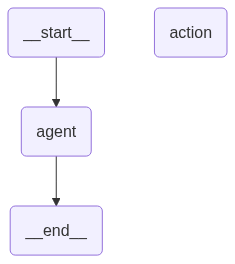

In [45]:
simple_agent_graph

#### ❓ Question #2:

Is there any specific limit to how many times we can cycle?

If not, how could we impose a limit to the number of cycles?

## Using Our Graph

Now that we've created and compiled our graph - we can call it *just as we'd call any other* `Runnable`!

Let's try out a few examples to see how it fairs:

In [46]:
from langchain_core.messages import HumanMessage

inputs = {"messages" : [HumanMessage(content="what's consistent hashing")]}

async for chunk in simple_agent_graph.astream(inputs, stream_mode="updates"):
    for node, values in chunk.items():
        print(f"Receiving update from node: '{node}'")
        print(values["messages"])
        print("\n\n")

Receiving update from node: 'agent'
[AIMessage(content="Consistent hashing is a technique used in distributed systems to evenly distribute data across multiple nodes or servers while minimizing the amount of data that needs to be redistributed when nodes are added or removed. It helps improve scalability and fault tolerance.\n\nIn consistent hashing, both data and nodes are mapped to a hash ring (a circular space of hash values). Each data item is assigned to the first node encountered when moving clockwise around the ring from the data's hash position. When a node joins or leaves, only a small portion of the data needs to be moved, making the system more efficient and resilient.\n\nWould you like a more detailed explanation or an example?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 129, 'prompt_tokens': 112, 'total_tokens': 241, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'r

Let's look at what happened:

1. Our state object was populated with our request
2. The state object was passed into our entry point (agent node) and the agent node added an `AIMessage` to the state object and passed it along the conditional edge
3. The conditional edge received the state object, found the "tool_calls" `additional_kwarg`, and sent the state object to the action node
4. The action node added the response from the OpenAI function calling endpoint to the state object and passed it along the edge to the agent node
5. The agent node added a response to the state object and passed it along the conditional edge
6. The conditional edge received the state object, could not find the "tool_calls" `additional_kwarg` and passed the state object to END where we see it output in the cell above!

Now let's look at an example that shows a multiple tool usage - all with the same flow!

In [47]:
inputs = {"messages" : [HumanMessage(content="what's kafka")]}

async for chunk in simple_agent_graph.astream(inputs, stream_mode="updates"):
    for node, values in chunk.items():
        print(f"Receiving update from node: '{node}'")
        if node == "action":
          print(f"Tool Used: {values['messages'][0].name}")
        print(values["messages"])

        print("\n\n")

Receiving update from node: 'agent'
[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_2LEuSyBRbUKOskr4MakSdrH4', 'function': {'arguments': '{"query":"Kafka"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 111, 'total_tokens': 129, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': 'fp_38343a2f8f', 'id': 'chatcmpl-C12J399xNVv8DGMzO03jCn7USWrni', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--13bff65b-1303-419e-b867-6d35c43abe97-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Kafka'}, 'id': 'call_2LEuSyBRbUKOskr4MakSdrH4', 'type': 'tool_call'}], usage_metadata={'input_tokens': 111,

In [48]:

from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
from ragas.testset import TestsetGenerator

generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1-nano"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)

In [49]:
len(docs)

269

In [50]:
from ragas.testset import TestsetGenerator
from ragas.testset.synthesizers import SingleHopSpecificQuerySynthesizer, MultiHopAbstractQuerySynthesizer

generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
dataset = generator.generate_with_langchain_docs(
    docs[:20], 
    testset_size=10,
    query_distribution=[(SingleHopSpecificQuerySynthesizer(llm=generator_llm), 1.0)]
)

Applying SummaryExtractor:   0%|          | 0/16 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/20 [00:00<?, ?it/s]

Node 6c3ed6fa-6338-4746-8a99-f94fe4dfdf40 does not have a summary. Skipping filtering.
Node 95e370a3-ccf4-45d6-90b3-45c4ce9280cd does not have a summary. Skipping filtering.
Node ff6dd9db-e99b-4d9d-87f5-5ff3faeb219f does not have a summary. Skipping filtering.
Node 1f6e0f53-b886-46bc-94a1-b8fb2f8f997a does not have a summary. Skipping filtering.


Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/53 [00:00<?, ?it/s]

Applying OverlapScoreBuilder:   0%|          | 0/1 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
dataset.to_pandas()

,user_input,reference_contexts,reference,synthesizer_name
0,Can you explain how Google Drive is designed t...,[Table of Contents\nSystem Design Interview: A...,Chapter 15 of the document is dedicated to des...,single_hop_specifc_query_synthesizer
1,How does Google relate to system design interv...,[FORWARD\nWe are delighted that you have decid...,The context mentions Google as an example of a...,single_hop_specifc_query_synthesizer
2,As a Backend Systems Engineer focusing on cach...,[1. Users access websites through domain names...,"In the context of web and mobile applications,...",single_hop_specifc_query_synthesizer
3,Amazon DynamoDB good?,"[Database\nWith the growth of the user base, o...","Amazon DynamoDB is a non-relational database, ...",single_hop_specifc_query_synthesizer
4,What is a load balancer used for?,[Load balancer\nA load balancer evenly distrib...,A load balancer evenly distributes incoming tr...,single_hop_specifc_query_synthesizer
5,Database does not support failover and redunda...,[so it does not support failover and redundanc...,The context states that the database does not ...,single_hop_specifc_query_synthesizer
6,"According to the information from Wikipedia, h...",[Database replication\nQuoted from Wikipedia: ...,"Database replication, as described in Wikipedi...",single_hop_specifc_query_synthesizer
7,What is Figure 1-5?,[operation even if a database is offline as yo...,Figure 1-5 shows the architectural design that...,single_hop_specifc_query_synthesizer
8,How does the HTPP protocol work in the context...,[Let us take a look at the design:\n• A user g...,The context describes that a user connects to ...,single_hop_specifc_query_synthesizer
9,What is a cache and how does it improve system...,[Cache\nA cache is a temporary storage area th...,A cache is a temporary storage area that store...,single_hop_specifc_query_synthesizer


In [57]:
from langchain_core.messages import SystemMessage, HumanMessage

inputs = {"messages" : [
     SystemMessage(content="You are a tutor that can answer questions about the system design and distributed systems. \
                  Only answer questions that are related to system design topics. \
                  If the question is related, use ai_rag_tool to get context first. If the context is not related or insufficient to answer the question, use tavily_tool to get context."),
    HumanMessage(content="How does Facebook address cache challenges and prevent single points of failure?")]
    }

res = simple_agent_graph.invoke(inputs)
res

{'messages': [SystemMessage(content='You are a tutor that can answer questions about the system design and distributed systems.                   Only answer questions that are related to system design topics.                   If the question is related, use ai_rag_tool to get context first. If the context is not related or insufficient to answer the question, use tavily_tool to get context.', additional_kwargs={}, response_metadata={}, id='586409e0-4c8b-44c3-992e-da2c7f178df2'),
  HumanMessage(content='How does Facebook address cache challenges and prevent single points of failure?', additional_kwargs={}, response_metadata={}, id='d13b181b-1870-4010-9e47-43d80637f6a3'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ttyjBOI2tHJvKrLlJjTArwH0', 'function': {'arguments': '{"question":"How does Facebook address cache challenges and prevent single points of failure?"}', 'name': 'ai_rag_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage'

In [52]:
res["messages"][-1].content

'Kafka is a distributed streaming platform used for building real-time data pipelines and streaming applications. It is designed to handle high-throughput, fault-tolerant, and scalable data streaming. Kafka allows producers to publish messages to topics, and consumers to subscribe to those topics to process the data in real-time. It is widely used in system architectures that require reliable and fast data transfer between different components or services.'

In [53]:
import re

def extract_page_contents(text):
    page_contents = []
    
    # Find all Document objects
    document_pattern = r"Document\(.*?page_content='(.*?)'\)"
    matches = re.finditer(document_pattern, text, re.DOTALL)
    
    for match in matches:
        page_content = match.group(1)
        # Unescape any escaped quotes
        page_content = page_content.replace("\\'", "'")
        page_contents.append(page_content)
    
    return page_contents


In [59]:
from langchain_core.messages import SystemMessage, HumanMessage

for test_row in dataset:
  inputs = {"messages" : [
    SystemMessage(content="You are a tutor that can answer questions about the system design and distributed systems. \
                  Only answer questions that are related to system design topics. \
                  If the question is related, use ai_rag_tool to get context first. If the context is not related or insufficient to answer the question, use tavily_tool to get context."),
    HumanMessage(content=test_row.eval_sample.user_input)
  ]}
  res = simple_agent_graph.invoke(inputs)
  test_row.eval_sample.response = res["messages"][-1].content
  page_contents = extract_page_contents(res["messages"][-2].content)
  test_row.eval_sample.retrieved_contexts = page_contents


In [60]:
dataset.to_pandas()

,user_input,retrieved_contexts,reference_contexts,response,reference,synthesizer_name
0,What is Google Drive used for?,[CHAPTER 15: DESIGN GOOGLE DRIVE\nIn recent ye...,[Table of Contents\nSystem Design Interview: A...,Google Drive is used for storing and syncing f...,The context mentions 'CHAPTER 15: DESIGN GOOGL...,single_hop_specifc_query_synthesizer
1,How does Google relate to system design interv...,[FORWARD\nWe are delighted that you have decid...,[FORWARD\nWe are delighted that you have decid...,Google is often used as an example in system d...,The context mentions Google as an example of a...,single_hop_specifc_query_synthesizer
2,How does the Hypertext Transfer Protocol funct...,[1. Users access websites through domain names...,[1. Users access websites through domain names...,The Hypertext Transfer Protocol (HTTP) functio...,"Once the IP address is obtained, Hypertext Tra...",single_hop_specifc_query_synthesizer
3,What is Couchdb?,"[Database\nWith the growth of the user base, o...","[Database\nWith the growth of the user base, o...",CouchDB is a non-relational (NoSQL) database t...,"CouchDB is a non-relational database, also cal...",single_hop_specifc_query_synthesizer
4,What does Figure 1-4 illustrate about the func...,[Load balancer\nA load balancer evenly distrib...,[Load balancer\nA load balancer evenly distrib...,Figure 1-4 illustrates that the function of a ...,Figure 1-4 shows how a load balancer works by ...,single_hop_specifc_query_synthesizer
5,Wikipedia help with database replication?,[Database replication\nQuoted from Wikipedia: ...,[Database replication\nQuoted from Wikipedia: ...,Wikipedia's approach to database replication p...,"Database replication, quoted from Wikipedia, c...",single_hop_specifc_query_synthesizer
6,What happens if the database goes offline and ...,[operation even if a database is offline as yo...,[operation even if a database is offline as yo...,"If the database goes offline, the system can c...","If a database goes offline, the system can sti...",single_hop_specifc_query_synthesizer
7,What role does DNS play in website load balanc...,[Let us take a look at the design:\n• A user g...,[Let us take a look at the design:\n• A user g...,DNS plays a crucial role in website load balan...,Let us take a look at the design: A user gets ...,single_hop_specifc_query_synthesizer
8,What does Figure 1-6 illustrate in relation to...,[Cache\nA cache is a temporary storage area th...,[Cache\nA cache is a temporary storage area th...,Figure 1-6 illustrates how caching reduces the...,"As illustrated in Figure 1-6, every time a new...",single_hop_specifc_query_synthesizer
9,How does Facebook address cache challenges and...,[the data store and cache is challenging. For ...,[the data store and cache is challenging. For ...,Facebook addresses cache challenges and preven...,Facebook mitigates cache challenges by recomme...,single_hop_specifc_query_synthesizer


In [171]:
dataset.to_pandas()

,user_input,retrieved_contexts,reference_contexts,response,reference,synthesizer_name
0,Can you explain how Google Drive is designed t...,[CHAPTER 15: DESIGN GOOGLE DRIVE\nIn recent ye...,[Table of Contents\nSystem Design Interview: A...,Google Drive is designed to handle large amoun...,Chapter 15 of the document is dedicated to des...,single_hop_specifc_query_synthesizer
1,How does Google relate to system design interv...,[FORWARD\nWe are delighted that you have decid...,[FORWARD\nWe are delighted that you have decid...,Google is often used as an example in system d...,The context mentions Google as an example of a...,single_hop_specifc_query_synthesizer
2,As a Backend Systems Engineer focusing on cach...,"[After receiving a request, a web server first...",[1. Users access websites through domain names...,JavaScript plays a crucial role in web and mob...,"In the context of web and mobile applications,...",single_hop_specifc_query_synthesizer
3,Amazon DynamoDB good?,"[Neo4j, Cassandra, HBase, Amazon DynamoDB, etc...","[Database\nWith the growth of the user base, o...",Amazon DynamoDB is considered a good choice fo...,"Amazon DynamoDB is a non-relational database, ...",single_hop_specifc_query_synthesizer
4,What is a load balancer used for?,[Load balancer\nA load balancer evenly distrib...,[Load balancer\nA load balancer evenly distrib...,A load balancer is used to evenly distribute i...,A load balancer evenly distributes incoming tr...,single_hop_specifc_query_synthesizer
5,Database does not support failover and redunda...,[so it does not support failover and redundanc...,[so it does not support failover and redundanc...,The database in question does not inherently s...,The context states that the database does not ...,single_hop_specifc_query_synthesizer
6,"According to the information from Wikipedia, h...",[Database replication\nQuoted from Wikipedia: ...,[Database replication\nQuoted from Wikipedia: ...,"Database replication, especially in a master/s...","Database replication, as described in Wikipedi...",single_hop_specifc_query_synthesizer
7,What is Figure 1-5?,"[In Figure 15-8, user 1 and user 2 tries to up...",[operation even if a database is offline as yo...,Figure 1-5 is not explicitly described in the ...,Figure 1-5 shows the architectural design that...,single_hop_specifc_query_synthesizer
8,How does the HTPP protocol work in the context...,[Let us take a look at the design:\n• A user g...,[Let us take a look at the design:\n• A user g...,The HTTP protocol works in the context of load...,The context describes that a user connects to ...,single_hop_specifc_query_synthesizer
9,What is a cache and how does it improve system...,[Cache\nA cache is a temporary storage area th...,[Cache\nA cache is a temporary storage area th...,A cache is a temporary storage area that store...,A cache is a temporary storage area that store...,single_hop_specifc_query_synthesizer


In [61]:
from ragas import EvaluationDataset

evaluation_dataset = EvaluationDataset.from_pandas(dataset.to_pandas())

In [62]:
from ragas import evaluate
from ragas.llms import LangchainLLMWrapper

evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1-mini"))

In [63]:
from ragas.metrics import LLMContextRecall, Faithfulness, ResponseRelevancy, ContextEntityRecall, ContextPrecision
from ragas import evaluate, RunConfig

custom_run_config = RunConfig(timeout=360)

result = evaluate(
    dataset=evaluation_dataset,
    metrics=[LLMContextRecall(), ContextPrecision(), Faithfulness(), ResponseRelevancy()],
    llm=evaluator_llm,
    run_config=custom_run_config
)


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

In [64]:
result

{'context_recall': 0.8524, 'context_precision': 0.8667, 'faithfulness': 0.7876, 'answer_relevancy': 0.9462}

In [ ]:
from uuid import uuid4

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "pdoc"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangSmith API Key: ")

In [175]:
result

{'context_recall': 0.9000, 'context_precision': 0.7222, 'faithfulness': 0.7502, 'answer_relevancy': 0.8535}

## advance retrieval


In [177]:
os.environ["COHERE_API_KEY"] = getpass.getpass("Cohere API Key:")


In [178]:
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_cohere import CohereRerank

compressor = CohereRerank(model="rerank-v3.5")
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=retriever
)